# Importing libraries

In [161]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from data_processing import *
from neural_net import *
from time import perf_counter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import LocallyLinearEmbedding
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [140]:
sns.set_style("darkgrid")
data = pd.read_csv("../Data/Postures.csv")
data

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78091,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-6.543114534,87.73336431,61.21636262,-62.1262783,?,?,?,?,?,?
78092,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,-62.13056257,78.22984739,33.07840718,-45.24954337,?,?,?,?,?,?
78093,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,3.835903706,78.59155401,32.32773754,-46.16655609,?,?,?,?,?,?
78094,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,-63.22162593,?,?,?,?,?,?,?,?,?


# Preprocessing

## Removing first line and last sensor

In [141]:
data = data.iloc[1:].drop(columns=['X11', 'Y11', 'Z11'])

In [142]:
data

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,?,?,?,?,?,?,?,?,?,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78091,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-53.12613552,61.49495221,101.205748,-6.543114534,87.73336431,61.21636262,-62.1262783,?,?,?
78092,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,-5.985370806,88.17723316,60.78064176,-62.13056257,78.22984739,33.07840718,-45.24954337,?,?,?
78093,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,-62.71873546,-1.779494904,98.08945927,3.835903706,78.59155401,32.32773754,-46.16655609,?,?,?
78094,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,3.394291313,88.46570937,60.05079084,-63.22162593,?,?,?,?,?,?


## Removing rows with empty values

In [143]:
data = data.replace('?', np.NaN).dropna()

In [144]:
data

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
1873,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,16.89114653,79.18559183,54.75346341,-72.46228512,20.73009976,132.8585117,35.50128702,35.49065615,99.725676,22.69018573
1874,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,22.80224331,83.93699268,151.6331261,16.7184032,79.20604508,54.73668064,-72.4281603,13.02386153,95.08330578,30.17355791
1875,2,0,80.775150,93.705283,-5.090904,63.479609,98.429524,11.161413,48.924111,154.340338,...,-71.88844942,13.28694155,95.05310762,30.49143616,35.41467133,99.69301101,22.72708953,83.5663024,151.7048256,16.33455193
1876,2,0,80.618164,93.781461,-5.012812,63.213130,98.462919,11.045095,48.777435,154.327283,...,-73.89450542,20.62818629,132.7875911,35.83607236,58.2066132,27.73422949,-71.96626336,13.29156092,95.01722785,30.65806178
1877,2,0,79.870413,93.921192,-5.628231,79.239570,55.197852,-72.374008,48.446947,154.215388,...,-72.37974832,20.45320276,132.6332823,36.13433858,93.11882649,137.1512305,2.451085617,12.96308693,94.88241348,30.55257628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74033,2,14,22.724359,140.761792,41.430610,56.268812,147.295022,27.407631,70.677113,139.331294,...,-45.64679372,-8.180059153,80.95508381,15.17047988,60.42910473,38.12047458,-54.97069672,17.83128454,93.22219181,18.25477977
74034,2,14,22.922980,140.741854,41.606789,70.830328,139.278365,9.500168,56.433410,147.288126,...,-46.3187478,42.10388058,103.2606644,9.980829485,18.01991984,93.18000479,18.49089809,60.37697041,38.11082771,-55.00701225
74035,2,14,70.548317,139.410581,9.226422,22.606471,140.860978,41.294478,0.470086,122.653042,...,10.02755116,72.87140834,57.59460704,-46.44873285,60.26442449,38.02988732,-55.12822029,18.14672293,93.14047947,18.85058605
74036,2,14,70.589808,139.416026,9.526545,56.342132,147.324775,27.773020,0.499983,122.604332,...,-4.87677483,41.89425206,103.3179064,10.00043794,17.84832506,93.38462184,18.51556894,60.35071005,38.1370945,-54.90385573


# Splitting data

We'll be using users with less than 300 rows as testing data.

In [145]:
data_users_for_testing = [i for i in data.User.unique() if len(data[data['User'] == i]) < 300]

In [146]:
data_users_for_testing

[4, 9]

In [208]:
len(test_data)

222

In [147]:
test_data = data[data['User'].isin(data_users_for_testing)].drop(columns=["User"])
data = data[~data['User'].isin(data_users_for_testing)].drop(columns=["User"])

In [215]:
labels.head()

1873    2
1874    2
1875    2
1876    2
1877    2
Name: Class, dtype: int64

In [148]:
data.Class.unique()

array([2, 5, 1])

In [149]:
test_data.Class.unique()

array([2, 5])

We will only be training using the classes: {1, 2, 5} and testing for classes {2, 5}

In [150]:
test_labels = test_data['Class']
labels = data['Class']
data = data.drop(columns=["Class"])
test_data = test_data.drop(columns=["Class"])

In [151]:
(train_data, validation_data, train_labels, validation_labels) = train_test_split(data, labels, test_size=0.15)

# Direct classification using KNN

In [152]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []

# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data, train_labels)

    # evaluate the model and update the accuracies list
    score = model.score(validation_data, validation_labels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))

k=1, accuracy=95.18%
k=3, accuracy=95.87%
k=5, accuracy=95.96%
k=7, accuracy=95.60%
k=9, accuracy=95.73%
k=11, accuracy=95.41%
k=13, accuracy=95.37%
k=15, accuracy=95.41%
k=17, accuracy=95.09%
k=19, accuracy=94.86%
k=21, accuracy=95.05%
k=23, accuracy=95.05%
k=25, accuracy=95.14%
k=27, accuracy=95.09%
k=29, accuracy=95.14%
k=5 achieved highest accuracy of 95.96% on validation data


In [153]:
# re-train our classifier using the best k value and predict the labels of the
# test data
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(data, labels)
predictions = model.predict(test_data)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(test_labels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           2       0.91      0.62      0.74       115
           5       0.69      0.93      0.80       107

    accuracy                           0.77       222
   macro avg       0.80      0.78      0.77       222
weighted avg       0.81      0.77      0.77       222



# Classification using KNN after dimensionality reduction

## Dimensionality reduction using LLE

### Hyper parameters

In [201]:
n_neighbors = 200
n_components = 30

In [202]:
clf = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='standard')
data_lle = clf.fit_transform(data)
train_data_lle = clf.fit_transform(train_data)
validation_data_lle = clf.fit_transform(validation_data)
test_data_lle = clf.fit_transform(test_data)

In [203]:
data_lle

array([[ 0.00900572,  0.0012252 ,  0.00456346, ..., -0.00540448,
         0.00185757, -0.00078909],
       [ 0.00683073,  0.00054151,  0.00191219, ..., -0.00266425,
         0.00260114, -0.00058187],
       [ 0.01144792,  0.00103756,  0.0043674 , ...,  0.0037052 ,
        -0.00605954,  0.00211356],
       ...,
       [ 0.00225755,  0.00022376,  0.00263905, ...,  0.00512599,
        -0.00075586, -0.00492716],
       [ 0.00399215,  0.00038937,  0.00276208, ...,  0.00084445,
         0.00082272, -0.00646693],
       [ 0.00631624,  0.00019447,  0.0035666 , ..., -0.00060901,
         0.00162982, -0.00399867]])

In [204]:
train_data_lle

array([[ 8.95658304e-03, -8.99635602e-04,  1.10067385e-03, ...,
        -8.14414653e-04,  1.10307094e-02, -1.15389562e-04],
       [-2.02135775e-03, -7.42191067e-04,  2.08993057e-03, ...,
         4.42516441e-03,  7.26279264e-03,  2.49581702e-04],
       [-1.03286086e-02, -7.77027114e-05,  1.33474990e-03, ...,
         6.11400654e-03, -8.23627189e-05, -2.81177616e-03],
       ...,
       [-3.55215980e-03,  7.99297433e-04, -1.16592517e-03, ...,
         6.15580083e-03,  4.46995091e-03,  6.56362748e-03],
       [ 2.15190411e-02, -2.98921383e-03,  2.19173983e-03, ...,
         2.09388447e-02,  1.32208828e-02, -1.78373422e-02],
       [-7.68209034e-03,  5.91690043e-04, -4.82462583e-04, ...,
         1.39474246e-03, -6.29284826e-03, -7.92152152e-04]])

In [205]:
validation_data_lle

array([[-0.00344033,  0.02972384,  0.01537184, ...,  0.02047668,
         0.03000648,  0.06173226],
       [ 0.00566371, -0.01654651, -0.02708553, ..., -0.03485396,
        -0.01663371, -0.00824093],
       [-0.00328079,  0.05628714, -0.02228411, ...,  0.01420127,
         0.02805478, -0.00262155],
       ...,
       [-0.01916862,  0.00751947, -0.02608323, ..., -0.02778997,
         0.01301461,  0.03831938],
       [-0.00356255,  0.02599082, -0.00797824, ...,  0.0320196 ,
        -0.03894024, -0.00251834],
       [-0.01455454, -0.02345189,  0.01162356, ...,  0.00264657,
         0.00177465, -0.00464934]])

In [206]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(250, 300, 2)
accuracies = []

# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(250, 300, 2):
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data_lle, train_labels)

    # evaluate the model and update the accuracies list
    score = model.score(validation_data_lle, validation_labels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))

k=250, accuracy=67.98%
k=252, accuracy=68.03%
k=254, accuracy=68.03%
k=256, accuracy=68.07%
k=258, accuracy=68.12%
k=260, accuracy=68.17%
k=262, accuracy=68.21%
k=264, accuracy=68.07%
k=266, accuracy=68.12%
k=268, accuracy=68.07%
k=270, accuracy=68.12%
k=272, accuracy=68.12%
k=274, accuracy=68.12%
k=276, accuracy=68.03%
k=278, accuracy=67.84%
k=280, accuracy=67.84%
k=282, accuracy=67.89%
k=284, accuracy=67.84%
k=286, accuracy=67.94%
k=288, accuracy=67.89%
k=290, accuracy=67.80%
k=292, accuracy=67.75%
k=294, accuracy=67.84%
k=296, accuracy=67.75%
k=298, accuracy=67.94%
k=262 achieved highest accuracy of 68.21% on validation data


In [207]:
# re-train our classifier using the best k value and predict the labels of the
# test data
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(data_lle, labels)
predictions = model.predict(test_data_lle)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(test_labels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           2       0.52      0.90      0.66       115
           5       0.52      0.11      0.18       107

    accuracy                           0.52       222
   macro avg       0.52      0.51      0.42       222
weighted avg       0.52      0.52      0.43       222



# Testing the DeepSet

In [185]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 6s 1us/step


In [186]:
import numpy as np
from typing import List, Tuple
from tqdm import tqdm_notebook as tqdm

def extract_image_set(x_data: np.array, y_data :np.array, agg_fun=np.sum, n_images=3) -> Tuple[np.array, np.array]:
  """
  Extract a single set of images with corresponding target
  :param x_data
  """
  idxs = np.random.randint(low=0, high=len(x_data)-1, size=n_images)
  return x_data[idxs], agg_fun(y_data[idxs])


def generate_dataset(n_samples: int, x_data: np.array, y_data :np.array, agg_fun=np.sum, n_images=3) -> Tuple[List[List[np.array]], np.array]:
  """
  :return X,y in format suitable for training/prediction 
  """
  generated_list = [extract_image_set(x_data, y_data, agg_fun, n_images) for i in tqdm(range(n_samples))]
  X, y = [i[0] for i in generated_list], np.array([t[1] for t in generated_list])
  output_lists = [[] for i in range(n_images)]
  for image_idx in range(n_images):
    for sample_idx in range(n_samples):
      output_lists[image_idx].append(np.expand_dims(X[sample_idx][image_idx], axis=2))
  return output_lists, y

X_train_data, y_train_data = generate_dataset(n_samples=100000, x_data=x_train, y_data=y_train, n_images=3)
X_test_data, y_test_data = generate_dataset(n_samples=20000, x_data=x_test, y_data=y_test, n_images=3)

/home/nessreddine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


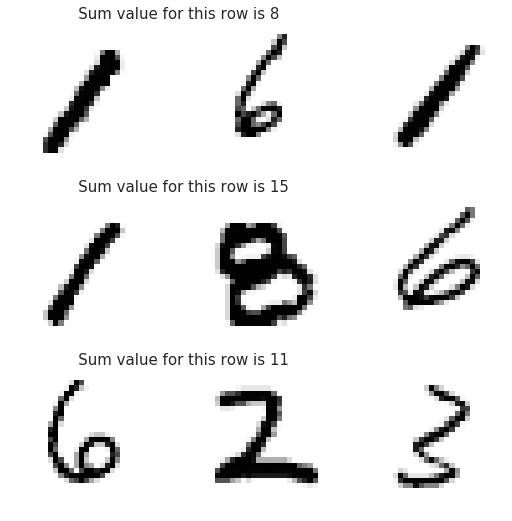

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline 

n_sample_viz, n_images = 3, 3

fig, axes = plt.subplots(nrows=n_sample_viz, ncols=n_images, figsize=(9.0, 9.0))

for sample_idx in range(n_sample_viz):
  for im_idx in range(n_images):
    axes[sample_idx, im_idx].imshow(X_train_data[im_idx][sample_idx][:, :, 0], cmap='Greys')
    axes[sample_idx, im_idx].axis('off')
    if im_idx==0:
      axes[sample_idx, 0].set_title('               Sum value for this row is {}'.format(y_train_data[sample_idx]), 
                                    fontsize=15, loc='left')

In [189]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import Adam

import os, datetime

input_shape = (28, 28, 1)
filters = 64
kernel_size = 3

# Shared portion of the network
input_image = Input(shape=input_shape)

y = Conv2D(32, kernel_size=(3, 3),
           activation='relu',
           input_shape=input_shape)(input_image)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)
y = Flatten()(y)
output_vec = Dense(128, activation='relu')(y)

feature_ext_model = Model(input_image, output_vec)

image_1, image_2, image_3 = Input(shape=input_shape), Input(shape=input_shape), \
                            Input(shape=input_shape)
outputs_1, outputs_2, outputs_3 = feature_ext_model(image_1), feature_ext_model(image_2), feature_ext_model(image_3)

y = Add()([outputs_1, outputs_2, outputs_3])
y = Dense(64, activation='relu')(y)
y = Dense(32, activation='relu')(y)
encoded = Dense(1)(y)

model = Model([image_1, image_2, image_3], encoded)
adam = Adam()
model.compile(optimizer=adam, loss='mae')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(x=X_train_data, y=y_train_data,
          epochs=10, batch_size=64)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 279s 3ms/sample - loss: 2.0116
Epoch 2/10
100000/100000 [==============================] - 283s 3ms/sample - loss: 0.9725
Epoch 3/10
 76928/100000 [======================>.......] - ETA: 1:02 - loss: 0.8592

KeyboardInterrupt: 

In [ ]:
prediction = model.predict(x=X_test_data)

import matplotlib.pyplot as plt
%matplotlib inline 

n_sample_viz, n_images = 4, 3

fig, axes = plt.subplots(nrows=n_sample_viz, ncols=n_images, figsize=(12.0, 12.0))
for sample_idx in range(n_sample_viz):
  for im_idx in range(n_images):
    axes[sample_idx, im_idx].imshow(X_test_data[im_idx][sample_idx][:, :, 0], cmap='Greys')
    axes[sample_idx, im_idx].axis('off')
    if im_idx==0:
      axes[sample_idx, 0].set_title('Sum value for this row is {}, prediction is {}'.format(y_test_data[sample_idx], round(prediction[sample_idx][0])), 
                                    fontsize=15, loc='left')